In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits

import time
import os
from pathlib import Path

import poppy

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
platform = jax.devices()[0].platform
device = jax.devices()[0].device_kind

print(f'Jax platform: {platform}')
print(f'Jax device: {device}')

import utils
import imshows
from imshows import *

wavelength = 633*u.nm
pupil_diam = 7.4*u.mm
fl = 150*u.mm
fnum = fl.to_value(u.mm)/pupil_diam.to_value(u.mm)

um_per_lamD = wavelength.to(u.um) * fnum
pixelscale_m = 3.45e-6
pixelscale_lamD = pixelscale_m / um_per_lamD.to_value(u.m)
print(pixelscale_m, pixelscale_lamD)

def pad_or_crop( arr_in, npix ):
    n_arr_in = arr_in.shape[0]
    if n_arr_in == npix:
        return arr_in
    elif npix < n_arr_in:
        x1 = n_arr_in // 2 - npix // 2
        x2 = x1 + npix
        arr_out = arr_in[x1:x2,x1:x2]
    else:
        arr_out = jnp.zeros((npix,npix), dtype=arr_in.dtype)
        x1 = npix // 2 - n_arr_in // 2
        x2 = x1 + n_arr_in
        arr_out = arr_out.at[x1:x2,x1:x2].set(arr_in)
    return arr_out

def crop(im, xc,yc,nim):
    return im[xc-nim//2:xc+nim//2, yc-nim//2:yc+nim//2]

def sum_ims(ims, exp_times, sat_thresh=100, nbits=12, plot=False, bias=None):
    total_flux = 0.0
    pixel_weights = 0.0
    for i in range(ims.shape[0]):
        frame = ims[i]
        exp_time = exp_times[i]
        pixel_sat_mask = frame > (2**nbits - sat_thresh)

        if bias is not None:
            frame -= bias
        
        pixel_weights += ~pixel_sat_mask
        flux_im = frame/exp_time
        flux_im[pixel_sat_mask] = 0 # mask out the saturated pixels

        if plot: 
            imshows.imshow3(pixel_sat_mask, frame, flux_im, 
                            'Pixel Saturation Mask', 
                            f'Frame:\nExposure Time = {exp_time}s', 
                            'Masked Flux Image', 
                            lognorm2=True, lognorm3=True)
            
        total_flux += flux_im
        
    total_flux_im = total_flux/pixel_weights

    return total_flux_im

Jax platform: gpu
Jax device: NVIDIA A100 80GB PCIe
3.45e-06 0.26887835703001584


# Load in data

In [34]:
long_defocus = np.array([ -2, -1, +1, +2, +3, +4]) # in mm
nim = 64

2325.0 4095.0 4095.0


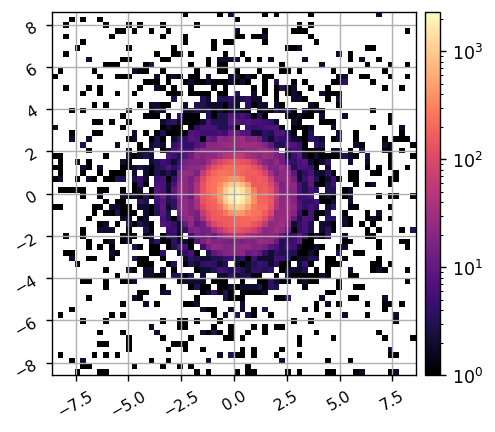

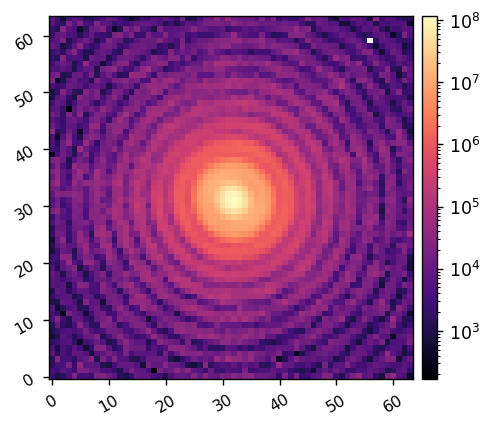

In [35]:
# -2
xc = 573
yc = 1009
tiff1 = f'data-fl150-pd7-2/defocus_{long_defocus[0]:d}mm_20us.tiff'
tiff2 = f'data-fl150-pd7-2/defocus_{long_defocus[0]:d}mm_200us.tiff'
tiff3 = f'data-fl150-pd7-2/defocus_{long_defocus[0]:d}mm_2000us.tiff'
im_def_1 = crop(plt.imread(tiff1), xc, yc, nim)/16
im_def_2 = crop(plt.imread(tiff2), xc, yc,  nim)/16
im_def_3 = crop(plt.imread(tiff3), xc, yc, nim)/16

print(im_def_1.max(), im_def_2.max(), im_def_3.max())

imshow1(im_def_1, lognorm=True, pxscl=pixelscale_lamD, grid=True, 
        # axlims=[55, 71, 55, 71],
        )

ims = np.array([im_def_1, im_def_2, im_def_3])
exp_times_def = [20e-6, 200e-6, 2000e-6]

def_im_n2 = sum_ims(ims, exp_times_def, 
                        # plot=True,
                        )
imshow1(def_im_n2, lognorm=True)

3466.0 4095.0 4095.0


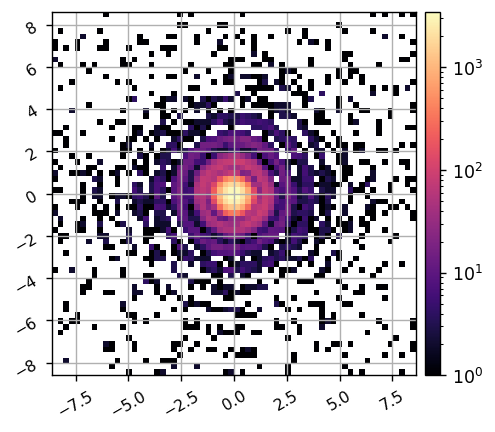

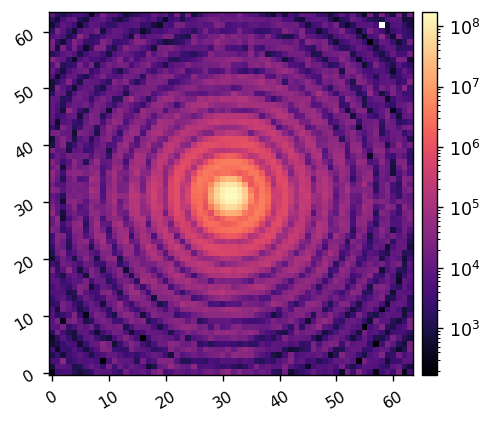

In [37]:
# -1
xc = 574
yc = 1010
tiff1 = f'data-fl150-pd7-2/defocus_{long_defocus[1]:d}mm_20us.tiff'
tiff2 = f'data-fl150-pd7-2/defocus_{long_defocus[1]:d}mm_200us.tiff'
tiff3 = f'data-fl150-pd7-2/defocus_{long_defocus[1]:d}mm_2000us.tiff'
im_def_1 = crop(plt.imread(tiff1), xc, yc, nim)/16
im_def_2 = crop(plt.imread(tiff2), xc, yc,  nim)/16
im_def_3 = crop(plt.imread(tiff3), xc, yc, nim)/16

print(im_def_1.max(), im_def_2.max(), im_def_3.max())

imshow1(im_def_1, lognorm=True, pxscl=pixelscale_lamD, grid=True, 
        # axlims=[55, 71, 55, 71],
        )

ims = np.array([im_def_1, im_def_2, im_def_3])
exp_times_def = [20e-6, 200e-6, 2000e-6]

def_im_n1 = sum_ims(ims, exp_times_def, 
                        # plot=True,
                        )
imshow1(def_im_n1, lognorm=True)

1975.0 4095.0 4095.0


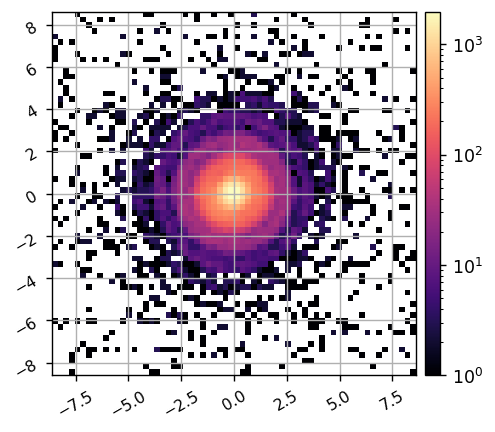

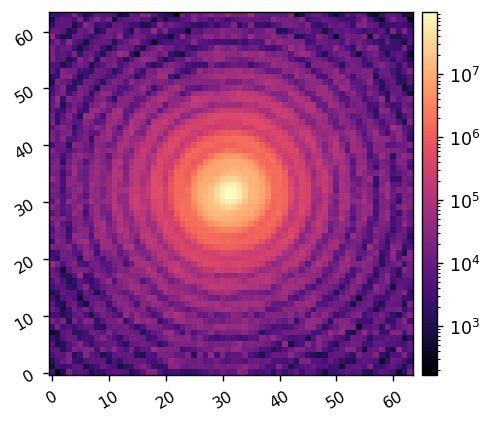

In [38]:
# +1
xc = 575
yc = 1011
tiff1 = f'data-fl150-pd7-2/defocus_+{long_defocus[2]:d}mm_20us.tiff'
tiff2 = f'data-fl150-pd7-2/defocus_+{long_defocus[2]:d}mm_200us.tiff'
tiff3 = f'data-fl150-pd7-2/defocus_+{long_defocus[2]:d}mm_2000us.tiff'
im_def_1 = crop(plt.imread(tiff1), xc, yc, nim)/16
im_def_2 = crop(plt.imread(tiff2), xc, yc,  nim)/16
im_def_3 = crop(plt.imread(tiff3), xc, yc, nim)/16

print(im_def_1.max(), im_def_2.max(), im_def_3.max())

imshow1(im_def_1, lognorm=True, pxscl=pixelscale_lamD, grid=True, 
        # axlims=[55, 71, 55, 71],
        )

ims = np.array([im_def_1, im_def_2, im_def_3])
exp_times_def = [20e-6, 200e-6, 2000e-6]

def_im_p1 = sum_ims(ims, exp_times_def, 
                        # plot=True,
                        )
imshow1(def_im_p1, lognorm=True)

912.0 4095.0 4095.0


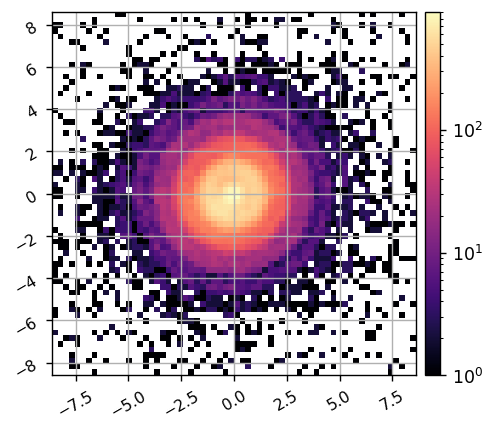

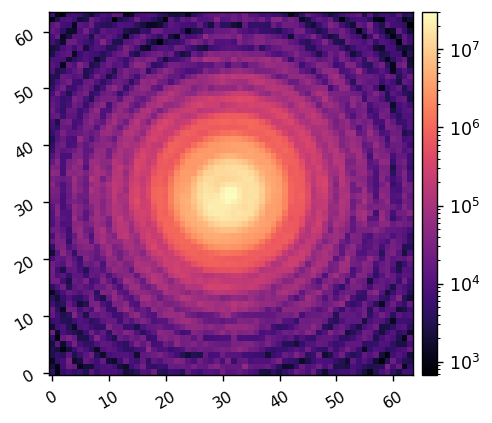

In [44]:
# +2
xc = 576
yc = 1012
tiff1 = f'data-fl150-pd7-2/defocus_+{long_defocus[3]:d}mm_30us.tiff'
tiff2 = f'data-fl150-pd7-2/defocus_+{long_defocus[3]:d}mm_300us.tiff'
tiff3 = f'data-fl150-pd7-2/defocus_+{long_defocus[3]:d}mm_3000us.tiff'
im_def_1 = crop(plt.imread(tiff1), xc, yc, nim)/16
im_def_2 = crop(plt.imread(tiff2), xc, yc,  nim)/16
im_def_3 = crop(plt.imread(tiff3), xc, yc, nim)/16

print(im_def_1.max(), im_def_2.max(), im_def_3.max())

imshow1(im_def_1, lognorm=True, pxscl=pixelscale_lamD, grid=True, 
        # axlims=[55, 71, 55, 71],
        )

ims = np.array([im_def_1, im_def_2, im_def_3])
exp_times_def = [30e-6, 300e-6, 3000e-6]

def_im_p2 = sum_ims(ims, exp_times_def, 
                        # plot=True,
                        )
imshow1(def_im_p2, lognorm=True)

3876.0 4095.0 4095.0


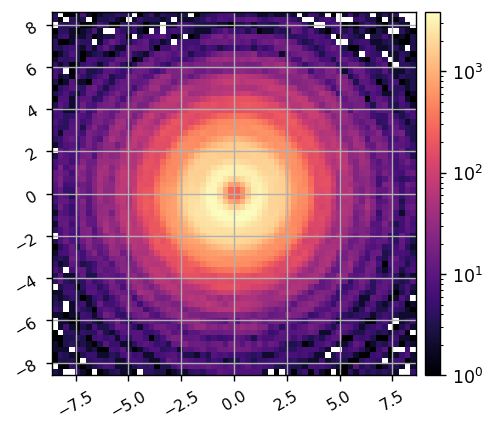

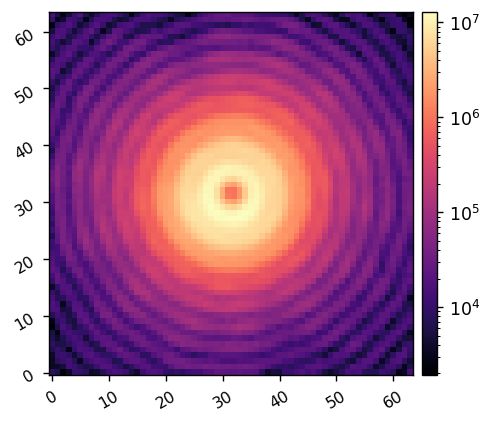

In [46]:
# +2
xc = 577
yc = 1012
tiff1 = f'data-fl150-pd7-2/defocus_+{long_defocus[4]:d}mm_300us.tiff'
tiff2 = f'data-fl150-pd7-2/defocus_+{long_defocus[4]:d}mm_3000us.tiff'
tiff3 = f'data-fl150-pd7-2/defocus_+{long_defocus[4]:d}mm_30000us.tiff'
im_def_1 = crop(plt.imread(tiff1), xc, yc, nim)/16
im_def_2 = crop(plt.imread(tiff2), xc, yc,  nim)/16
im_def_3 = crop(plt.imread(tiff3), xc, yc, nim)/16

print(im_def_1.max(), im_def_2.max(), im_def_3.max())

imshow1(im_def_1, lognorm=True, pxscl=pixelscale_lamD, grid=True, 
        # axlims=[55, 71, 55, 71],
        )

ims = np.array([im_def_1, im_def_2, im_def_3])
exp_times_def = [300e-6, 3000e-6, 30000e-6]

def_im_p3 = sum_ims(ims, exp_times_def, 
                        # plot=True,
                        )
imshow1(def_im_p3, lognorm=True)

3854.0 4095.0 4095.0


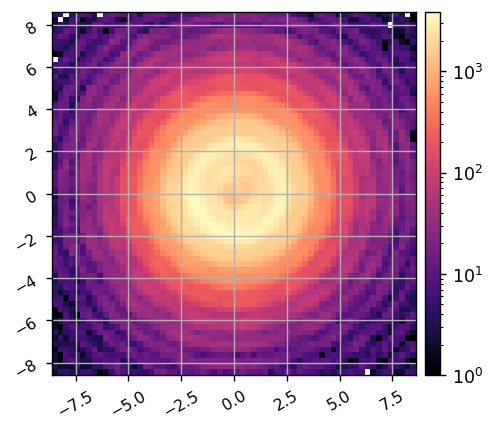

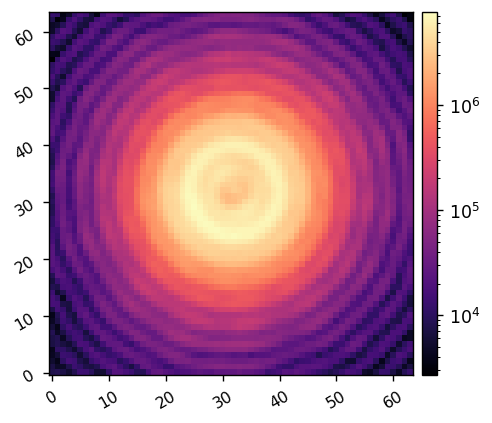

In [47]:
# +4
xc = 578
yc = 1013
tiff1 = f'data-fl150-pd7/defocus-{long_defocus[5]:d}mm-500us.tiff'
tiff2 = f'data-fl150-pd7/defocus-{long_defocus[5]:d}mm-5000us.tiff'
tiff3 = f'data-fl150-pd7/defocus-{long_defocus[5]:d}mm-50000us.tiff'
im_def_1 = crop(plt.imread(tiff1), xc, yc, nim)/16
im_def_2 = crop(plt.imread(tiff2), xc, yc,  nim)/16
im_def_3 = crop(plt.imread(tiff3), xc, yc, nim)/16

print(im_def_1.max(), im_def_2.max(), im_def_3.max())

imshow1(im_def_1, lognorm=True, pxscl=pixelscale_lamD, grid=True, 
        # axlims=[55, 71, 55, 71],
        )

ims = np.array([im_def_1, im_def_2, im_def_3])
exp_times_def = [500e-6, 5000e-6, 50000e-6]

def_im_p4 = sum_ims(ims, exp_times_def, 
                        # plot=True,
                        )
imshow1(def_im_p4, lognorm=True)

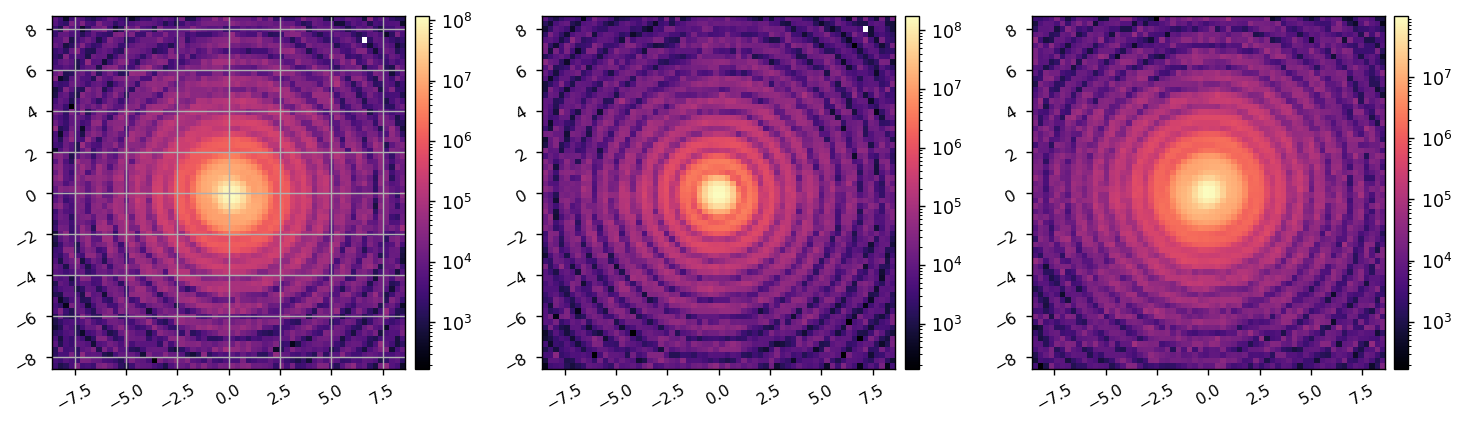

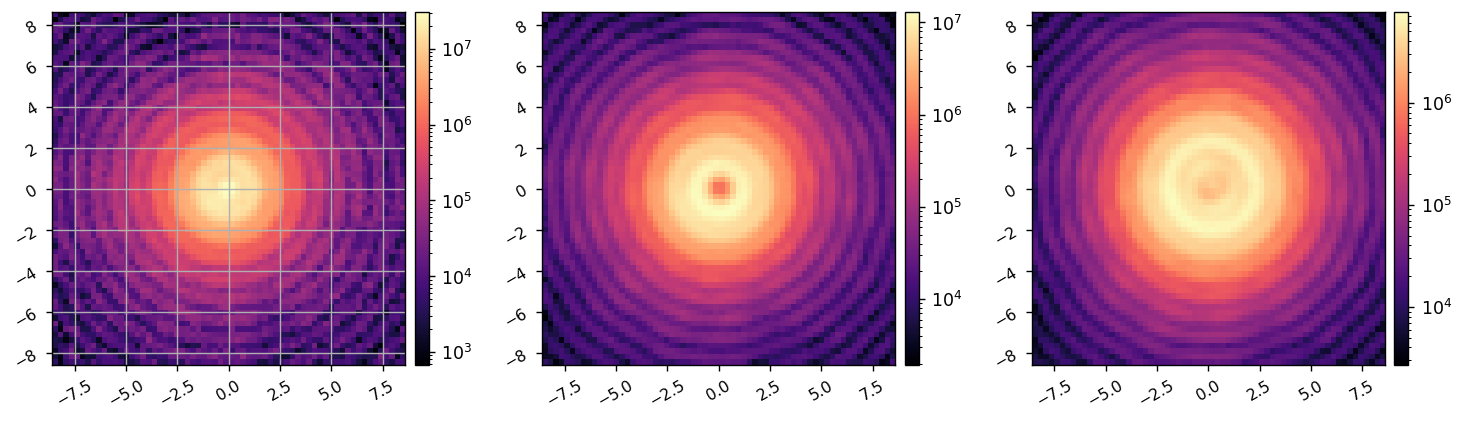

In [48]:
imshow3(def_im_n2, def_im_n1, def_im_p1, lognorm=True, pxscl=pixelscale_lamD, grid=True)
imshow3(def_im_p2, def_im_p3, def_im_p4, lognorm=True, pxscl=pixelscale_lamD, grid=True)

# Make the model and run the estimation

In [29]:
npix = 512
wf = poppy.FresnelWavefront(beam_radius=pupil_diam/2, npix=npix, oversample=1)
ap = poppy.NgonAperture(nsides=14, radius=pupil_diam/2, rotation=1).get_transmission(wf)

Oversampling > 2x suggested for reliable results in Fresnel propagation.


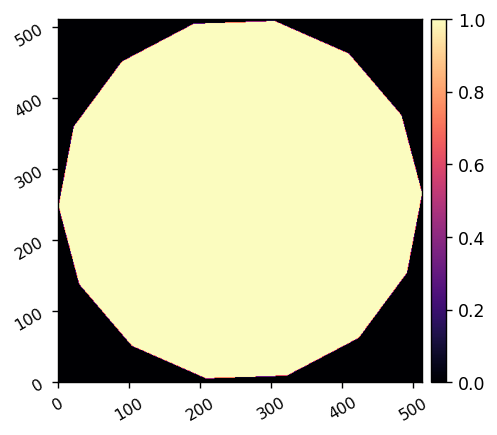

In [30]:
imshow1(ap)

In [31]:
utils.save_fits(f'aperture_14_{npix:d}.fits', ap.get())

Saved data to:  aperture_14_512.fits


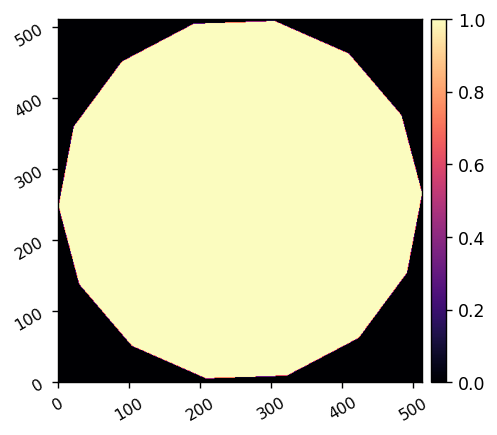

In [49]:
npix = 512
ap = jnp.asarray(fits.getdata(f'aperture_14_{npix:d}.fits'))
imshow1(ap)

In [84]:
!nvidia-smi

Tue Apr 30 21:18:24 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          Off |   00000000:25:00.0 Off |                    0 |
| N/A   35C    P0             63W /  300W |   77706MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

# Initialize the model and do the estimation

In [50]:
import estimation
import model

wavelengths = jnp.array([wavelength.to_value(u.m)])
spectrum = jnp.linspace(1, 1, num=1)

In [52]:
long_defocus/1000

array([-0.002, -0.001,  0.001,  0.002,  0.003,  0.004])

In [19]:
fnum

20.27027027027027

In [76]:
print(long_defocus)

nim = 64

mod = model.ForwardModel(npix, nim, fnum, pixelscale_m, 
                           wavelength.to_value(u.m), wavelengths, 
                           long_defocus/1000/2, 
                        #    spectrum=spectrum, 
                           )


[-2 -1  1  2  3  4]


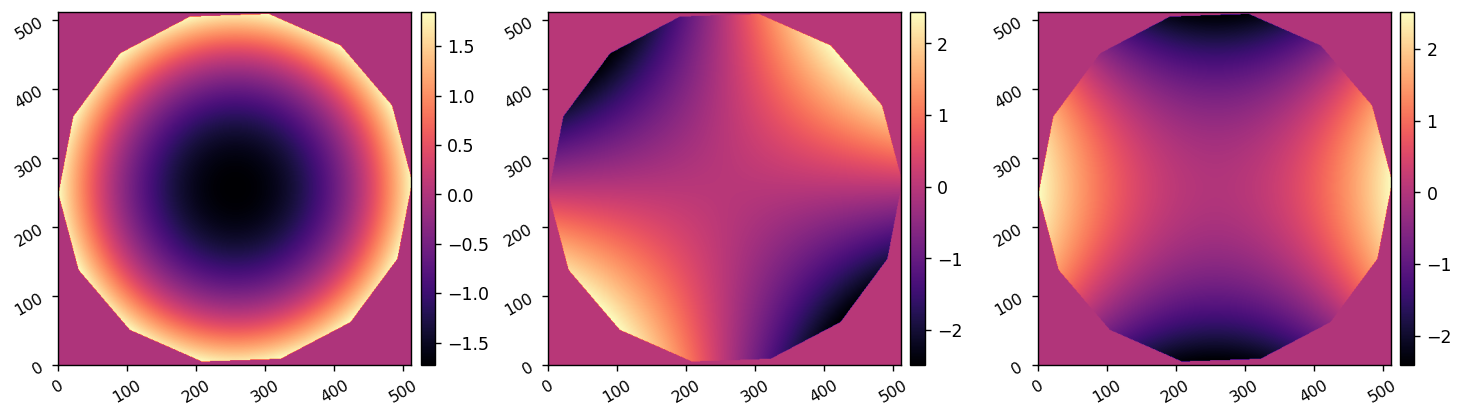

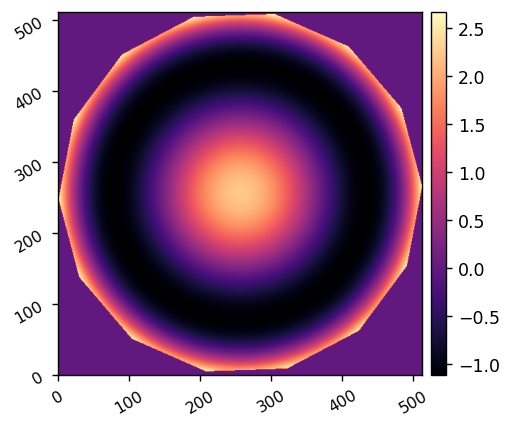

In [77]:
nmodes = 10
zmodes = poppy.zernike.arbitrary_basis(ap, nterms=nmodes+3, outside=0)[3:]
modes = zmodes.reshape(nmodes, npix**2).T
imshow3(zmodes[0], zmodes[1], zmodes[2])
imshow1(zmodes[7])

In [78]:
# estimator = estimation.Estimation(mod, estimate_phase=True, maxiter=1000, wreg=1e-10)
# estimator = estimation.Estimation(mod, estimate_phase=True, estimate_amplitude=True, maxiter=100, wreg=1e-2)

estimator = estimation.Estimation(mod, estimate_phase=True, maxiter=100, wreg=1e-6,
                                  phase_modal=True, 
                                  modes=jnp.asarray(zmodes.get()))

In [79]:
# psfs = jnp.array([total_im_def1, total_im_def2, total_im_def3, total_im_def4])
psfs = jnp.array([def_im_n2, def_im_n1, def_im_p1, def_im_p2, def_im_p3, def_im_p4])

In [80]:
fit, err, objvals = estimator.run(psfs, ap)

INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.9838158889891551 Stepsize:1.0  Decrease Error:0.9838158889891551  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 2 Minimum Decrease & Curvature Errors (stop. crit.): 0.9821129151367103 Stepsize:0.49999999999856426  Decrease Error:0.9821129151367103  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 3 Minimum Decrease & Curvature Errors (stop. crit.): 0.9863581127780405 Stepsize:0.21132486540292578  Decrease Error:0.9863581127780405  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 4 Minimum Decrease & Curvature Errors (stop. crit.): 0.9866908195015406 Stepsize:0.0921961441867519  Decrease Error:0.9866908195015406  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 5 Minimum Decrease & Curvature Errors (stop. crit.): 0.9820786670593594 Stepsize:0.04000451461733238  Decrease Error:0.9820786670593594  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 6 Minimum Decreas

2024-05-01 14:09:14.173757: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none


INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 2.0040182177833524e-34 Stepsize:1.0  Decrease Error:1.8477733024029651e-34  Curvature Error:2.0040182177833524e-34 
INFO: jaxopt.ZoomLineSearch: Iter: 2 Minimum Decrease & Curvature Errors (stop. crit.): 1.188684315793475e-34 Stepsize:0.5  Decrease Error:1.0324394004130875e-34  Curvature Error:1.188684315793475e-34 
INFO: jaxopt.ZoomLineSearch: Iter: 3 Minimum Decrease & Curvature Errors (stop. crit.): 3.161920009948637e-35 Stepsize:0.25  Decrease Error:1.5994708561447623e-35  Curvature Error:3.161920009948637e-35 
INFO: jaxopt.ZoomLineSearch: Iter: 4 Minimum Decrease & Curvature Errors (stop. crit.): 1.4237128399678744e-35 Stepsize:0.125  Decrease Error:0.0  Curvature Error:1.4237128399678744e-35 
INFO: jaxopt.ZoomLineSearch: Iter: 5 Minimum Decrease & Curvature Errors (stop. crit.): 5.880654772408272e-35 Stepsize:0.0625  Decrease Error:0.0  Curvature Error:5.880654772408272e-35 
INFO: jaxopt.ZoomL

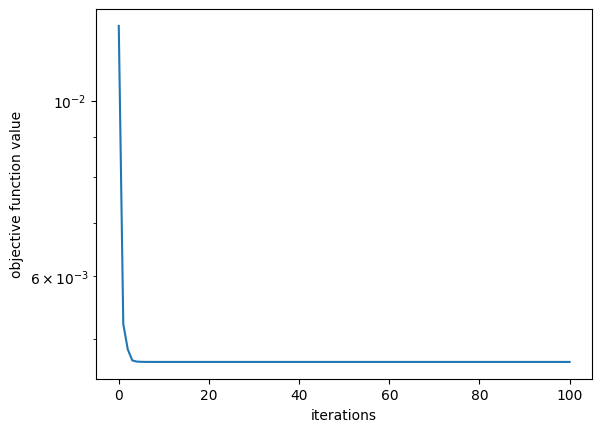

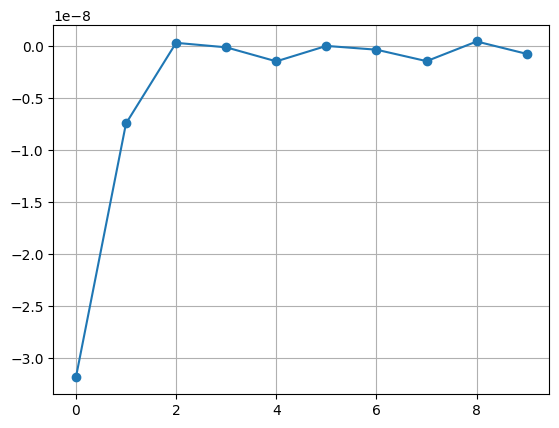

In [81]:
plt.semilogy(objvals)
plt.xlabel('iterations')
plt.ylabel('objective function value')
plt.show()

plt.plot(range(nmodes), fit[-1], '-o')
plt.grid()

In [82]:
fit[-1]

Array([-3.19183834e-08, -7.49222936e-09,  2.63675928e-10, -1.68064935e-10,
       -1.51675613e-09, -3.21874699e-11, -3.96068538e-10, -1.49763337e-09,
        3.94207451e-10, -7.99946460e-10], dtype=float64)

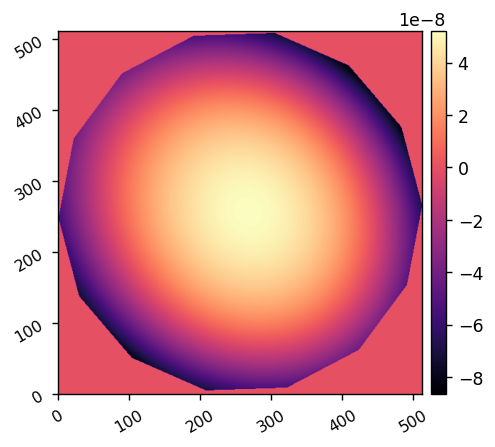

In [83]:
opd_est = modes.get().dot(fit[-1]).reshape(npix,npix)
est_wfe = ap*(opd_est)
imshow1(est_wfe)

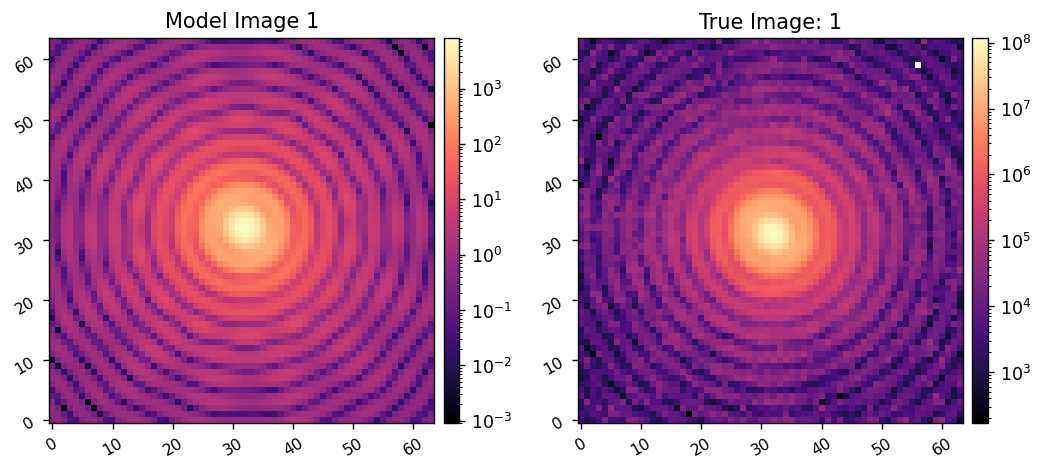

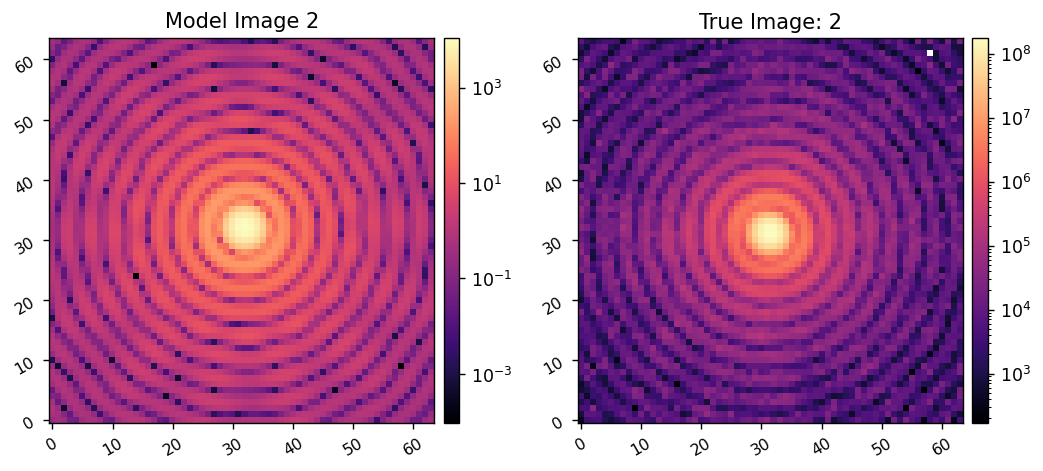

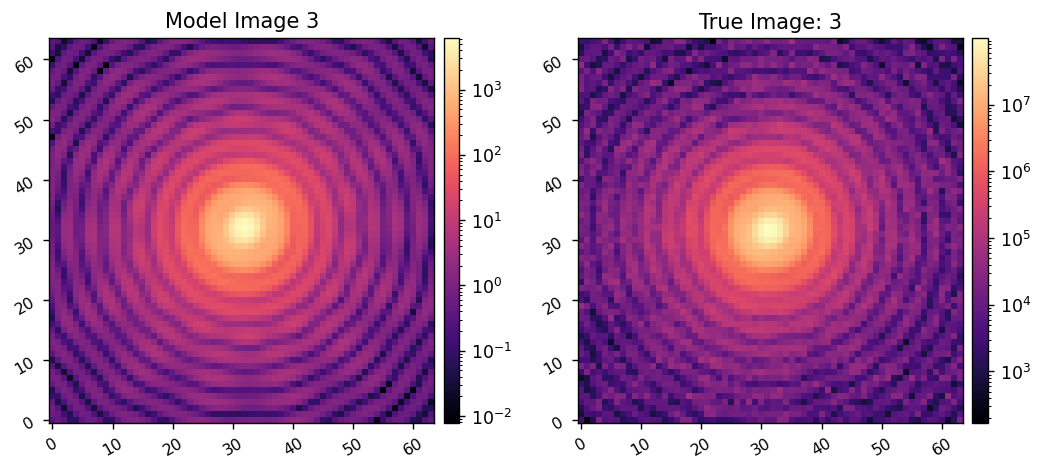

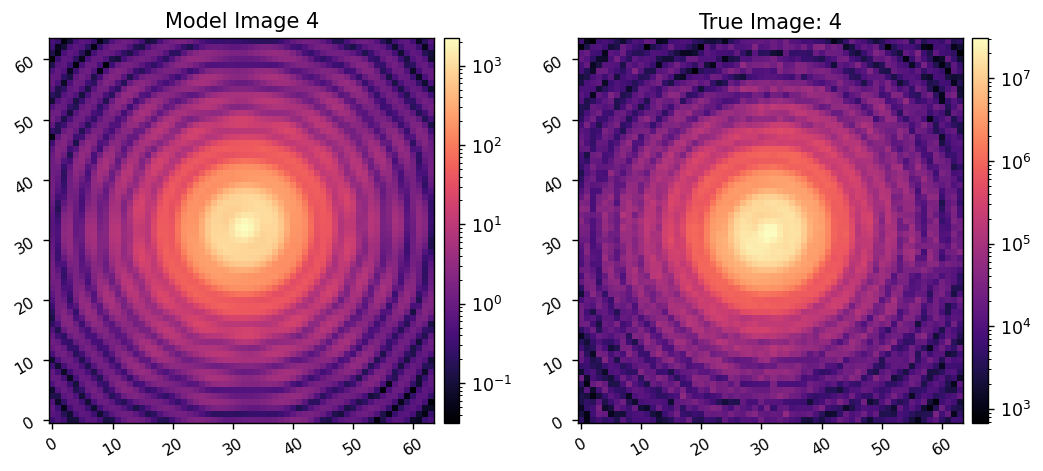

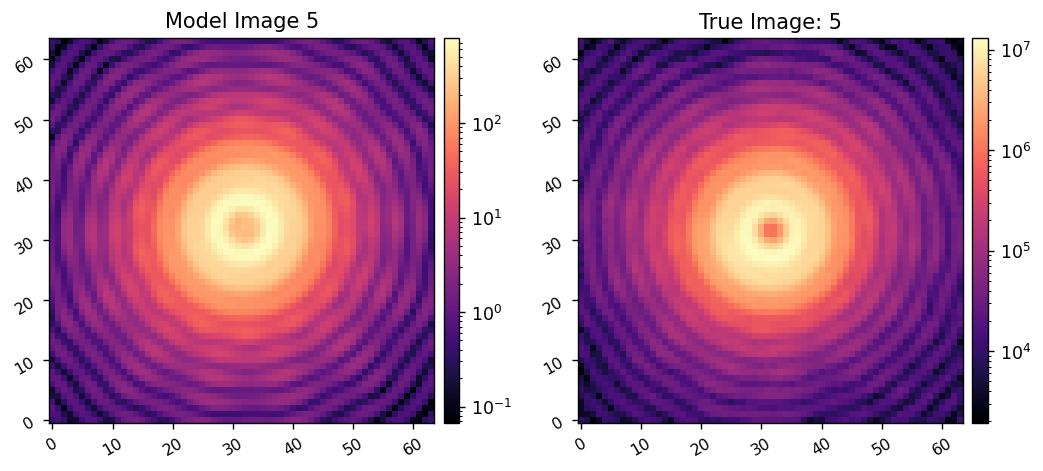

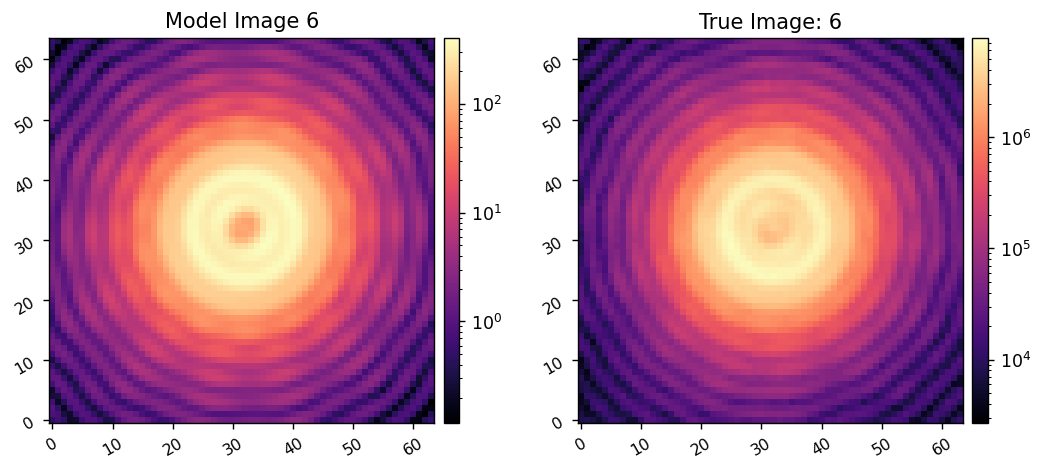

In [84]:
model_psfs = model.forward_propagate(ap, est_wfe, mod.wavelengths, mod.fresnel_TFs, mod.Mx, mod.My)

for i in range(len(long_defocus)):
    imshow2(model_psfs[i], psfs[i], f'Model Image {i+1:d}', f'True Image: {i+1:d}', lognorm=True)